# Change jupyter config

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

# Libraries

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
from operator import itemgetter
import json
from matplotlib import cm
import matplotlib.colors as colors
import seaborn as sns
import pandas as pd
from matplotlib.ticker import FormatStrFormatter

In [3]:
plot_save_dir = "/home/kaijunge/Documents/PhD/CREATE Lab Git Repo/Raspberry/raspberry-grasping/data/plots_kai"
# plot_save_dir = "/Users/kaijunge/Documents/PhD/gitlab/raspberry-grasping/data/plots_kai"

# Directory handling

In [4]:
# populate data store dictionary
datas = {
            "Lab":{"High":[], "Medium":[], "Low":[]}, 
            "Field":{"High":[], "Medium":[], "Low":[], "Other":{}}
        }

target_names = {"Compression":"Fc", "Pulling":"Fp", "Time":"Time", "Init":"Arm_pos", "Gripper":"Gripper_pos"}
target_keys = list(target_names.keys())

In [5]:
# Lab vs Field directory

for location in ["Lab", "Field"]:
    
    for force_setting in ["Low", "Medium", "High"]:

        folder_path =  "raspberry-robot-plots-data/Lab Vs Field/" + location + "/wo K2/" + force_setting + " Force"

        if location == "Lab":
            datas[location][force_setting] = {"Time":{}, "Fc":{}, "Fp":{}, "Gripper_pos":{}, "Arm_pos":{}}
            for subdir, dirs, files in os.walk(folder_path):
                if subdir == folder_path:
                    continue

                folder_name = subdir[len(folder_path) + 1:]

                target = ""
                
                for key in target_keys:
                    if key in folder_name:
                        target = target_names[key]
                        break
                        
                if target != "":
                    for file in files:
                        f = subdir + "/" + file
                        exp_id = int(file[-5:-4])
                        csv = np.genfromtxt(f, delimiter=',')
                        
                            
                        if target =="Fp" or target == "Fc":
                            datas[location][force_setting][target][exp_id] = csv * (9.8 / 1000)
                        else:
                            datas[location][force_setting][target][exp_id] = csv

        else:
            datas[location][force_setting] = {"Time":[], "Fc":[], "Fp":[], "Gripper_pos":[], "Arm_pos":[]}
            
            for file_path in os.listdir(folder_path):
                f = os.path.join(folder_path, file_path)
                                          
                # checking if it is a file
                if os.path.isfile(f):
#                     print(file_path)
                    target = ""
                    for key in target_keys:
                        if key in file_path:
                            target = target_names[key]
                            break

                    if target != "":
                        csv = np.genfromtxt(f, delimiter=',')
                        
                        if target =="Fp" or target == "Fc":
                            datas[location][force_setting][target].append(csv * (9.8 / 1000))
                        else:
                            datas[location][force_setting][target].append(csv)
                            

In [6]:
# Day 1 trials data collection
ID_to_level = {
                "Low":[17, 19, 20, 22, 25, 28, 30, 31, 35, 36, 37, 38, 39, 40],
                "Medium":[18, 23, 26, 44],
                "High":[34, 49, 46, 33, 32]
                }

folder_path =  "raspberry-robot-plots-data/Day 1 trials"
location = "Field"

for subdir, dirs, files in os.walk(folder_path):
    if subdir == folder_path:
        continue

    folder_name = subdir[len(folder_path) + 1:]
#     print(folder_name)

    force_level = ""
    for lvl in ["Low", "Medium", "High"]:
        if int(folder_name) in ID_to_level[lvl]:
            force_level = lvl
    
    if force_level == "":
        force_level = "Other"
            
#     print(folder_name, force_level)
    
    if force_level == "Other":
        datas[location][force_level][folder_name] = {"Time":[], "Fc":[], "Fp":[], "Gripper_pos":[], "Arm_pos":[]}
        save_location = datas[location][force_level][folder_name]
    else:
        save_location = datas[location][force_level]
    
    new_folder_path = folder_path + "/" + folder_name

    for file_path in os.listdir(new_folder_path):
        f = os.path.join(new_folder_path, file_path)

        if os.path.isfile(f):
            target = ""
            for key in target_keys:
                if key in file_path:
                    target = target_names[key]
                    break
                    
            if target != "":
                csv = np.genfromtxt(f, delimiter=',')
                
                if target =="Fp" or target == "Fc":
                    save_location[target].append(csv * (9.8 / 1000))
                else:
                    save_location[target].append(csv)

# Helper functions

In [7]:
def get_harvest_index(force_data):
    harvest_index = 0
    max_value = 0
    for i in range(len(force_data)-1):
        diff = abs(force_data[i] - force_data[i+1])

        if diff > max_value:
            max_value = diff
            harvest_index = i
            
    return harvest_index

def adjust_time_series(time_data, index, time_before_pull):
    time_at_index = time_data[index]
    
    time_data = time_data - time_at_index + time_before_pull
    
    return time_data

def get_pull_index_and_adjust_time(force_data, time_data, time_before_pull):
    index = get_harvest_index(force_data)
    return adjust_time_series(time_data, index, time_before_pull)

# Plotting

In [8]:
low_colour = '#f0d002'
low_error_colour = '#8a7701'
medium_colour = '#eb8602'
medium_error_colour = '#7a4601'
high_colour = '#e30291'
high_error_colour = '#94015f'
robot_field = '#74C4C0'
robot_lab = 'C0'
setpoint_color1 = '#f7c728'
setpoint_color2 = '#fca821'
setpoint_color3 = '#fc7c19'
setpoint_color4 = '#f5ec42'

setpoint_width = 5

In [9]:
# Constants
Fc_ylim = {"Low":[-0.1, 2.5], "Medium":[-0.1, 2.5], "High":[-0.1, 2.5]}

# {"Low":, "Medium":, "High":}
time_before_pull = {"Low":7, "Medium":7, "High":10}
time_after_pull = {"Low":1.5, "Medium":1.5, "High":1.5}

sp1 = {"Low":0.75, "Medium":2, "High":2.8}
sp2 = {"Low":0.42, "Medium":0.42, "High":0.42}

field_results_to_plot = {"Low":[], "Medium":[0], "High":[0,3,4]}
extra_results_to_plot = {"Low":["56"], "Medium":[], "High":[]}


lab_main = {"Low":0, "Medium":0, "High":0}
field_main = {"Low":0, "Medium":0, "High":1}

ncol = {"Low":3, "Medium":2, "High":1}

setpoint_color = {"Low":setpoint_color1, "Medium":setpoint_color2, "High":setpoint_color3}

label_font = 20
legend_font = 16
tick_font = 16

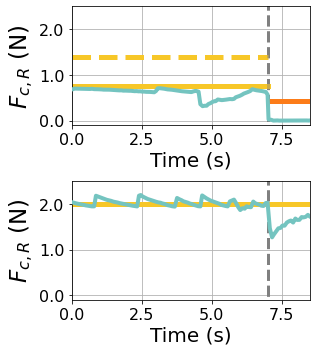

In [14]:
filename = "faliure_cases"

def populate_data_array(location, force_lvl, index, folder_name = ""):
    
    if force_lvl == "Other":
        comp_force_data = datas[location][force_lvl][folder_name]["Fc"][index]
        pull_force_data = datas[location][force_lvl][folder_name]["Fp"][index]
        time_data_temp = datas[location][force_lvl][folder_name]["Time"][index]
        force_lvl = "High"
    else:
        comp_force_data = datas[location][force_lvl]["Fc"][index]
        pull_force_data = datas[location][force_lvl]["Fp"][index]
        time_data_temp = datas[location][force_lvl]["Time"][index]

    time_data = get_pull_index_and_adjust_time(pull_force_data, time_data_temp, time_before_pull[force_lvl])

    pull_datas.append([pull_force_data, location])
    comp_datas.append([comp_force_data, location])
    time_datas.append([time_data, location])

    
fig, axs = plt.subplots(2, 1, figsize = (4.5, 5))

for fl_count, fl in enumerate(["Low", "Medium"]):
    
    # Define time settings
    total_time = time_before_pull[fl] + time_after_pull[fl]

    # Make Controller setpoint curve
    ctrl1 = [np.linspace(0, time_before_pull[fl], 1000), np.linspace(sp1[fl], sp1[fl], 1000)]
    ctrl2 = [np.linspace(time_before_pull[fl], total_time, 1000), np.linspace(sp2[fl], sp2[fl], 1000)]
    transition = [[time_before_pull[fl], time_before_pull[fl]], [1000, -1000]]

    pull_datas = []
    comp_datas = []
    time_datas = []

    # First go through all the data to get relevant time series
#     for lab_results_idx in lab_results_to_plot[fl]:
#         populate_data_array("Lab", fl, lab_results_idx)

    for field_resutls_idx in field_results_to_plot[fl]:
        populate_data_array("Field", fl, field_resutls_idx)
        
    for extra_resutls_idx in extra_results_to_plot[fl]:
        populate_data_array("Field", "Other", 0, extra_resutls_idx)


#     axs[fl_count].plot(ctrl1[0], ctrl1[1], color = setpoint_color[fl], linewidth = setpoint_width)
#     axs[fl_count].plot(ctrl2[0], ctrl2[1], color = setpoint_color4, linewidth = setpoint_width)
    
    axs[fl_count].plot(transition[0], transition[1], color = "grey", linewidth = 3, linestyle = "--")
    axs[fl_count].grid()

    curve_query = {"Lab":{"count":0, "main":lab_main[fl], "color":robot_lab}, 
                   "Field":{"count":0, "main":field_main[fl], "color":robot_field}}

    for i in range(len(time_datas)):
        loc = time_datas[i][1]

        linewidth = 1.5
        alpha = 0.7
        if curve_query[loc]["main"] == curve_query[loc]["count"]:
            linewidth = 4
            alpha = 1

        color = curve_query[loc]["color"]
        curve_query[loc]["count"] += 1

        if fl_count == 0:
            time_data = time_datas[i][0] - 3
        else:
            time_data = time_datas[i][0]
        axs[fl_count].plot(time_data, comp_datas[i][0], color = color, linewidth = linewidth, alpha = alpha, zorder = 100)
        
    if fl_count == 0:
        axs[0].plot(ctrl1[0], ctrl1[1], color = setpoint_color1, linewidth = setpoint_width, alpha = 1)
        axs[0].plot(ctrl2[0], ctrl2[1], color = setpoint_color3, linewidth = setpoint_width, alpha = 1)


        axs[0].plot([ctrl1[0][0], ctrl1[0][-1]], [1.4, 1.4], color = setpoint_color1,linestyle = "--", linewidth = setpoint_width, alpha = 1)
    else:
        axs[1].plot([ctrl1[0][0], 10], [2,2], color = setpoint_color1, linestyle = "-", linewidth = setpoint_width, alpha = 1)


    axs[fl_count].set_ylim(Fc_ylim[fl])
    
    #axs[fl_count].set_xlabel("Time (s)", fontsize = label_font)
    axs[fl_count].plot([0,1], [100,100], color = setpoint_color1, label = "$F_c^1$")
    axs[fl_count].plot([0,1], [100,100], color = setpoint_color3, label = "$F_c^2$")

    axs[fl_count].set_xlim([0,total_time])
    axs[fl_count].plot(transition[0], transition[1], color = "grey", linewidth = 3, linestyle = "--", alpha = 0.4)
    axs[fl_count].tick_params(axis='both', which='major', labelsize=tick_font)
    axs[fl_count].yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
    axs[fl_count].plot([0,1], [100,100], color = robot_field, label = "$F_{c,R}$")
    
#     if fl_count == 1:
#         leg = axs[fl_count].legend(fontsize = legend_font, ncol = ncol[fl], loc='upper center', bbox_to_anchor=(0.5, 1.5), framealpha = 1, handlelength = 1, columnspacing = 1, )

#         for line in leg.get_lines():
#             line.set_linewidth(6.0)        

    axs[fl_count].set_ylabel("$F_{c,R}$ (N)", fontsize = label_font + 3)

    axs[fl_count].set_xlabel("Time (s)", fontsize = label_font)

for i in range(2):
    axs[i].plot([0,1], [100,100], color = setpoint_color[fl], linewidth = setpoint_width, alpha = 0.4)


plt.tight_layout()
# plt.savefig(plot_save_dir + '/'+ filename + '.pdf')  
plt.show()